# Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.
Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

Данные находятся в файле ***autos.csv***.

Признаки:

**DateCrawled** — дата скачивания анкеты из базы   
**VehicleType** — тип автомобильного кузова   
**RegistrationYear** — год регистрации автомобиля   
**Gearbox** — тип коробки передач   
**Power** — мощность (л. с.)   
**Model** — модель автомобиля   
**Kilometer** — пробег (км)   
**RegistrationMonth** — месяц регистрации автомобиля   
**FuelType** — тип топлива   
**Brand** — марка автомобиля   
**NotRepaired** — была машина в ремонте или нет   
**DateCreated** — дата создания анкеты   
**NumberOfPictures** — количество фотографий автомобиля   
**PostalCode** — почтовый индекс владельца анкеты (пользователя)   
**LastSeen** — дата последней активности пользователя   

Целевой признак:

**Price** — цена (евро)

# Порядок выполнения проекта

1. Загрузить и подготовить данные;
2. Обучить разные модели с различными гиперпараметрами;
3. Проанализировать скорость работы и качество моделей.

Примечания:

1. Для построения моделей градиентного бустинга необходимо использовать библиотеку LightGBM;
2. Для оценки качества модели - использовать RMSE.

# 1. Подготовка данных

Импортируем необходимые модули:

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from time import time
from IPython.display import display

import lightgbm as lgb
import catboost as cat
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor


R = 987             #Random State
matplotlib.rcParams['figure.figsize'] = (10, 4)

Изучим полученный датасет:

In [8]:
dirname = './datasets/'
autos = pd.read_csv(dirname + 'autos.csv')

autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,nan,1993,manual,0,golf,150000,0,petrol,volkswagen,nan,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,nan,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,nan,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


В полученной таблице 354369 строк, 16 столбцов. Типы данных: *object* (строковый) и *int64* (целочисленный). В некоторых столбцах (**VehicleType**, **Gearbox**, **Model**, **FuelType** и **NotRepaired**) присутствуют пропуски.

Прежде чем производить предобработку данных, определимся с тем, какие признаки необходимы для построения модели. Целевым признаком является цена автомобиля (столбец **Price**). Логично предположить, что цена не будет зависеть от таких параметров, как дата скачивания анкеты из базы, количество фотографий, почтовый индекс продавца и некоторых других. Выделим список признаков, которые нам не понадобятся, и уберем соответствующие столбцы из таблицы:

In [4]:
redundant_feats = [
                   'DateCrawled', 
                   'DateCreated',
                   'RegistrationMonth',
                   'NumberOfPictures', 
                   'PostalCode', 
                   'LastSeen',
                  ]
features = autos.drop(columns = redundant_feats)
features.shape

(354369, 10)

Оставшиеся признаки разберем подробнее. Начнем с целевого признака (цена). Построим гистограмму распределения:

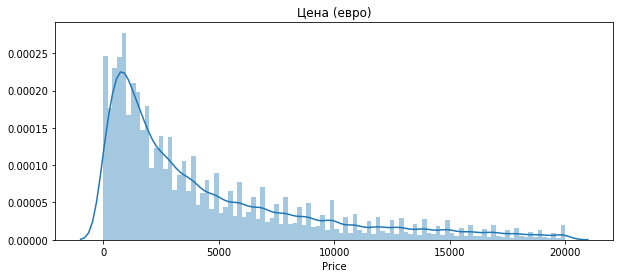

In [5]:
sns.distplot(features['Price'], bins=100)
plt.title('Цена (евро)')
plt.show()

В целом распределение похоже на нормальное, если не считать максимума рядом с нулем. Гребенчатый вид графика можно объяснить тем, что цену, как правило, устанавливают кратной 50/100/500 евро. Посмотрим подробнее на значения целевой переменной вблизи 0:

In [6]:
features['Price'].value_counts().head(5)

0       10772
500      5670
1500     5394
1000     4649
1200     4594
Name: Price, dtype: int64

Цены начиная от 500 евро вполне правдоподобны, а вот нулевые значения являются пропусками и для построения модели бесполезны. Удалим соответствующие записи из таблицы:

In [7]:
features = features.loc[features['Price'] != 0]
print('Осталось записей:', features.shape[0])

Осталось записей: 343597


Разберемся с остальными признаками:

### RegistrationYear

In [8]:
features['RegistrationYear'].describe()

count    343597.000000
mean       2004.089797
std          78.413225
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Столбец принимает значения от 1000 до 9999, что, конечно же, неверно. Возможно, недопустимые значения связаны с ошибками при ручном вводе значений либо при их сохранении. Ограничим допустимые даты регистрации диапазоном 1970 - 2020, а остальные записи удалим:

In [9]:
features = features.query('1970 < RegistrationYear < 2020')
print('Осталось записей:', features.shape[0])

Осталось записей: 342052


Посмотрим распределение значений столбца:

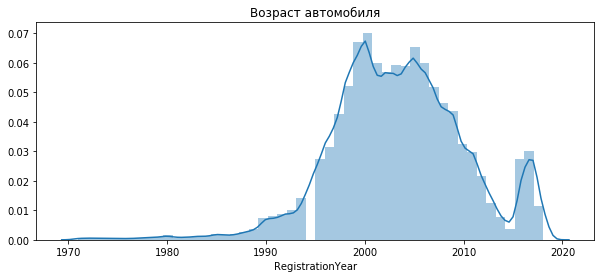

In [10]:
sns.distplot(features['RegistrationYear'], bins=50)
plt.title('Возраст автомобиля')
plt.show()

Теперь распределение похоже на настоящее.

### Power
Теперь изучим столбец **Power**:

In [11]:
features['Power'].describe()

count    342052.000000
mean        111.142356
std         186.130530
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Тут, как видно, также есть недопустимые значения. Значение 0, скорее всего, означает, что мощность не была указана, а значения выше 500 - ошибочно введенные или сохраненные значения. Отбросим записи, в которых указана мощность двигателя менее 50 или более 500 л.с.:

Осталось записей: 296033


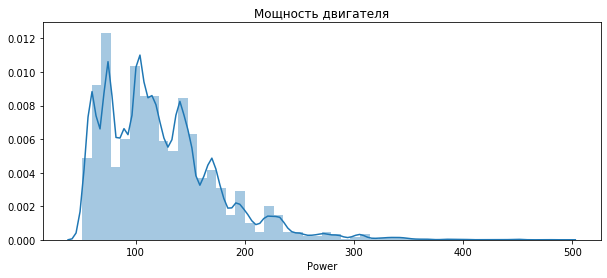

In [12]:
features = features.query('50 < Power < 500')
print('Осталось записей:', features.shape[0])
sns.distplot(features['Power'], bins=50)
plt.title('Мощность двигателя')
plt.show()

### Kilometer
Рассмотрим значения столбца **Kilometer**:

In [13]:
features['Kilometer'].value_counts()

150000    197751
125000     31510
100000     12570
90000      10189
80000       8937
70000       7693
60000       6722
50000       5588
40000       4422
30000       3838
20000       3205
5000        2739
10000        869
Name: Kilometer, dtype: int64

Здесь видно, что, во-первых, значения пробега квантованы с шагом 10000 (в среднем), а также тот факт, что большая часть значений находится в точке 150000. Предположительно, пробег автомобиля выбирается из списка вида 'до 10000 км, до 20000 км..., свыше 150000 км'. Поскольку таблица содержит предложения о продаже подержанных автомобилей, логично, что максимум значения находится в точке 150000 (пробег выше 150 тысяч км).

Поскольку все значения кратны тысяче, укажем в данном столбце пробег в тысячах км:

In [14]:
features['Kilometer'] = features['Kilometer'] / 1000
features['Kilometer'].value_counts()

150.0    197751
125.0     31510
100.0     12570
90.0      10189
80.0       8937
70.0       7693
60.0       6722
50.0       5588
40.0       4422
30.0       3838
20.0       3205
5.0        2739
10.0        869
Name: Kilometer, dtype: int64

Теперь перейдем к категориальным данным:

### FuelType

Изучим признак **FuelType**:

In [15]:
features['FuelType'].fillna('NaN').value_counts()

petrol      183309
gasoline     88676
NaN          18500
lpg           4763
cng            493
hybrid         204
other           55
electric        33
Name: FuelType, dtype: int64

Пропуски в данном случае возникают, если тип топлива не указан. Поскольку их довольно много, заменим из значением *unknown* (неизвестно). Также отметим, что *petrol* и *gasoline* по сути являются синонимами и их можно привести к одному значению:

In [16]:
features['FuelType'].fillna('unknown', inplace=True)
features['FuelType'].mask(features['FuelType'] == 'petrol', 'gasoline', inplace=True)
features['FuelType'].value_counts() # Проверка

gasoline    271985
unknown      18500
lpg           4763
cng            493
hybrid         204
other           55
electric        33
Name: FuelType, dtype: int64

### Gearbox

Рассмотрим значения признака **Gearbox**:

In [17]:
features['Gearbox'].fillna('NaN').value_counts()

manual    231374
auto       59206
NaN         5453
Name: Gearbox, dtype: int64

Пропуски в этом поле, на наш взгляд, целесообразно заполнить наиболее частым значением (*manual*):

In [18]:
features['Gearbox'].fillna('manual', inplace = True)
features['Gearbox'].value_counts()

manual    236827
auto       59206
Name: Gearbox, dtype: int64

### Not repaired

In [19]:
features['NotRepaired'].fillna('NaN').value_counts()

no     223377
NaN     44378
yes     28278
Name: NotRepaired, dtype: int64

В столбце **NotRepaired** пропусков достаточно много, при этом данная информация может быть важна при определении цены. Заполним пропуски значением *unknown*:

In [20]:
features['NotRepaired'].fillna('unknown', inplace = True)
features['NotRepaired'].value_counts()

no         223377
unknown     44378
yes         28278
Name: NotRepaired, dtype: int64

### Model

Модель автомобиля, как видится, является определяющим признаком для рассчета цены, поэтому записи, где данный признак отсутствует, для обучения модели не подходят. удалим их:

In [21]:
features.dropna(subset=['Model'], inplace=True)
print('Осталось записей:', features.shape[0])

Осталось записей: 284599


### VehicleType
Что касается типа кузова, можно попробовать заполнить пропуски на основании записей, где модель автомобиля та же, у тип кузова указан:

In [22]:
def fill_na_by_category(column_to_fill, category, aggfunc = 'mean'):

    ''' Функция для заполнения пропусков рассчетным значением по категории'''

    filled_vals_dict = (features.groupby(category)[column_to_fill]
                        .transform(aggfunc))  #группируем по категории и находим расчетное значение для группы
    features[column_to_fill].fillna(filled_vals_dict, inplace = True) # заполняем пропуски рассчетным значением
    print(f'В столбце {column_to_fill} осталось {features[column_to_fill].isna().sum()} пропусков') # проверка

fill_na_by_category('VehicleType', 
                    ['Brand', 'Model'], 
                    lambda x:x.mode()[0])

В столбце VehicleType осталось 0 пропусков


С помощью функции *fill_na_by_category* мы сделали следующее: сгруппировали все записи по марке и модели автомобиля, для каждой группы нашли наиболее частое значение (моду) и у тех автомобилей, где не указан тип кузова, заполнили пропуски этим значением. Понятно, что бывают модели, которые выпускаются в нескольких типах кузова (седан и хэтчбек, например), но как представляется, на итоговую работу модели это повлияет не сильно.

# 2. Предобработка данных

Выделим целевой признак в переменную ***target***:

In [23]:
target = features['Price']
features.drop(columns = 'Price', inplace = True)
features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
2,suv,2004,auto,163,grand,125.0,gasoline,jeep,unknown
3,small,2001,manual,75,golf,150.0,gasoline,volkswagen,no
4,small,2008,manual,69,fabia,90.0,gasoline,skoda,no
5,sedan,1995,manual,102,3er,150.0,gasoline,bmw,yes
6,convertible,2004,manual,109,2_reihe,150.0,gasoline,peugeot,no


Категориальные признаки закодируем с помощью OrdinalEncoder:

In [24]:
encoder = OrdinalEncoder()
cat_features_list = [
                     'VehicleType', 
                     'Gearbox', 
                     'Model', 
                     'FuelType', 
                     'Brand',
                     'NotRepaired'
                    ]
features[cat_features_list] = encoder.fit_transform(features[cat_features_list])
features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
2,6.0,2004,0.0,163,116.0,125.0,2.0,14.0,1.0
3,5.0,2001,1.0,75,115.0,150.0,2.0,37.0,0.0
4,5.0,2008,1.0,69,100.0,90.0,2.0,31.0,0.0
5,4.0,1995,1.0,102,11.0,150.0,2.0,2.0,2.0
6,1.0,2004,1.0,109,8.0,150.0,2.0,25.0,0.0


Преобразуем признаки в тип int:

In [25]:
features = features.astype('int16')
features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
2,6,2004,0,163,116,125,2,14,1
3,5,2001,1,75,115,150,2,37,0
4,5,2008,1,69,100,90,2,31,0
5,4,1995,1,102,11,150,2,2,2
6,1,2004,1,109,8,150,2,25,0


Выделим обучающую, валидационную и тестовую выборки:

In [26]:
train_feats, valid_feats, train_target, valid_target = train_test_split(features, 
                                                                        target, 
                                                                        train_size = 0.6,
                                                                        random_state = R)
valid_feats, test_feats, valid_target, test_target = train_test_split(valid_feats, 
                                                                      valid_target, 
                                                                      train_size = 0.5,
                                                                      random_state = R)

print(f'''Размеры выборок:

Обучающая \t {train_feats.shape[0]}
Валидационная \t {valid_feats.shape[0]}
Тестовая \t {test_feats.shape[0]}''')

Размеры выборок:

Обучающая 	 170759
Валидационная 	 56920
Тестовая 	 56920


# 3. Обучение моделей

В качестве моделей регрессии воспользуемся регрессорами на основе градиентного бустинга из библиотек LightGBM, CatBoost и XGBoost. Для каждой модели определим время обучения, скорость предсказания и качество модели (по метрике RMSE).

Но сперва для оценки качества наших моделей построим пару простых моделей, по которым будем оценивать вменяемость. В качестве одной из них используем dummy-регрессор, возвращающий медианное значение цены:

In [27]:
dummy_model = DummyRegressor(strategy='median')
dummy_model.fit(train_feats, train_target)
prediction = dummy_model.predict(valid_feats)
dummy_rmse = mean_squared_error(valid_target, prediction)**0.5
print('RMSE для dummy-модели:', dummy_rmse)

RMSE для dummy-модели: 4905.505345962037


Как видим, ошибка весьма значительна, особенно если учесть, что средняя цена находится в районе 3 - 4 тысяч евро.

Также попробуем построить модель на основе алгоритма "Случайный лес". Для нее найдем ошшибку на валидационных и тестовых данных, а также время обучения и предсказания:

In [28]:
rf_model = RandomForestRegressor(n_estimators = 100, criterion='mse') #параметры по умолчанию

t = time()
rf_model.fit(train_feats, train_target)
t_fit = time() - t
print(f'Обучение закончено. Время обучения {round(t_fit, 3)} секунд')

Обучение закончено. Время обучения 53.443 секунд


In [29]:
t = time()
prediction = rf_model.predict(valid_feats)
t_predict = time() - t
print(f'Предсказание закончено. Время предсказания {round(t_predict, 3)} секунд')

Предсказание закончено. Время предсказания 2.519 секунд


In [30]:
rf_rmse_valid = np.sqrt(mean_squared_error(valid_target, prediction))
rf_rmse_test = np.sqrt(mean_squared_error(test_target, rf_model.predict(test_feats)))
# датасет для результатов:
results = pd.DataFrame(columns=['RMSE на валидации', 
                                'RMSE на тестовом наборе', 
                                'Время обучения', 
                                'Время предсказания'])
results.loc['Random Forest'] = rf_rmse_valid, rf_rmse_test, t_fit, t_predict
results

,RMSE на валидации,RMSE на тестовом наборе,Время обучения,Время предсказания
Random Forest,1617.910505,1611.02517,53.443079,2.518729


У случайного леса даже без подбора гиперпараметров RMSE ощутимо лучше, чем у Dummy. В дальнейшем наши модели будем сравнивать с результатами случайного леса

Теперь перейдем к построению моделей градиентного бустинга:

## LightGBM

Приведем данные к требуемому формату (lightgbm.Dataset):

In [31]:
lgb_train = lgb.Dataset(train_feats, train_target, free_raw_data=False, categorical_feature=cat_features_list)
lgb_valid = lgb.Dataset(valid_feats, valid_target, free_raw_data=False, categorical_feature=cat_features_list)

Построим модель и обучим ее на тренировочных данных:

In [32]:
# параметры бустинга
lgb_parameters = {
    'boosting_type': 'gbdt',
    'application': 'regression',
    'metric': 'rmse',
    'seed': R
    }

t = time()
lgb_model = lgb.train(lgb_parameters, lgb_train, valid_sets=[lgb_train, lgb_valid], verbose_eval=25)
t_fit = time() - t
print(f'Обучение закончено. Время обучения {round(t_fit, 3)} секунд,', 
      f'RMSE на валидации - {lgb_model.best_score["valid_1"]["rmse"]}')
#del lgb_model

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[25]	training's rmse: 1823.92	valid_1's rmse: 1843.94
[50]	training's rmse: 1650.93	valid_1's rmse: 1675.97
[75]	training's rmse: 1602.7	valid_1's rmse: 1636.45
[100]	training's rmse: 1573.08	valid_1's rmse: 1617.36
Обучение закончено. Время обучения 7.577 секунд, RMSE на валидации - 1617.363246415883


Как видно, с параметрами по умолчанию качество модели почти не отличается от случайного леса, а обучение происходит намного быстрее. Попробуем подобрать оптимальные гиперпараметры: скорость обучения, количество итераций, и прочие: 

In [33]:
def train_time(lib, **kwargs):
    
    '''Обучение модели и замер времени'''
    
    t = time()
    model = lib.train(**kwargs)
    t_fit = time() - t
    print(f'Обучение закончено. Время обучения {round(t_fit, 3)} секунд')
    
    return model, t_fit

In [34]:
lgb_parameters['num_leaves'] = 512
lgb_parameters['learning_rate'] = 0.03
lgb_parameters['max_bin'] = 512
lgb_parameters['bagging_fraction'] = 0.8
lgb_parameters['bagging_freq'] = 1

lgb_model, t_fit = train_time(lgb, 
                              params=lgb_parameters, 
                              train_set=lgb_train, 
                              num_boost_round=1000, 
                              valid_sets=[lgb_train, lgb_valid], 
                              verbose_eval=100, 
                              early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1475.95	valid_1's rmse: 1585.66
[200]	training's rmse: 1336.32	valid_1's rmse: 1522.18
[300]	training's rmse: 1276.91	valid_1's rmse: 1512.5
[400]	training's rmse: 1236.99	valid_1's rmse: 1509.15
[500]	training's rmse: 1205.25	valid_1's rmse: 1508.48
Early stopping, best iteration is:
[452]	training's rmse: 1219.85	valid_1's rmse: 1508.35
Обучение закончено. Время обучения 153.487 секунд


Проверим качество модели на тестовых данных, а также найдем скорость предсказания:

In [35]:
def predict_time(model, test):
    '''Находит RMSE на тестовых данных и время предсказания'''
    t = time()
    prediction = model.predict(test)
    t_predict = time() - t
    rmse_test = np.sqrt(mean_squared_error(test_target, prediction))
    print(f'Предсказание завершено. Время - {round(t_predict, 4)} сек, RMSE на тестовом наборе - {rmse_test}')
    return rmse_test, t_predict

rmse_test, t_predict = predict_time(lgb_model, test_feats)
results.loc['LightGBM'] = [lgb_model.best_score['valid_1']['rmse'], rmse_test, t_fit, t_predict]

Предсказание завершено. Время - 14.7127 сек, RMSE на тестовом наборе - 1499.1182336983488


Нам удалось добиться лучшего качества, чем при использовании случайного леса, а также добиться выигрыша в скорости обучения. 

Посмотрим важность признаков в модели:

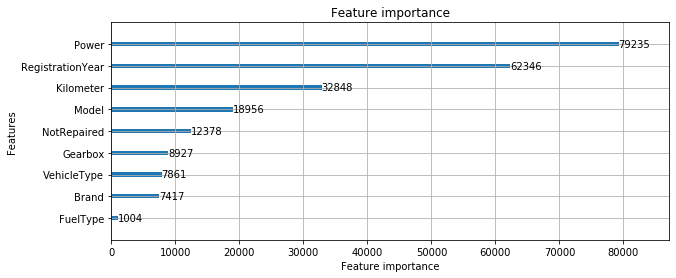

In [36]:
lgb.plot_importance(lgb_model)
plt.show()

## CatBoost

Теперь реализуем градиентный бустинг с использованием CatBoost:

In [37]:
# Преобразуем данные в объект catboost.Pool
cb_train = cat.Pool(train_feats, label=train_target)
cb_valid = cat.Pool(valid_feats, label=valid_target)

In [38]:
cb_parameters = {
    'loss_function': 'RMSE',
    'use_best_model': True,
    'random_seed': R,
#     'task_type': 'GPU',
    'learning_rate': 0.05,
    'depth': 9,
    'bagging_temperature': 0,
    'random_strength': 3,
#     'rsm': 0.7,
}

cb_model, t_fit = train_time(cat, 
                             pool=cb_train, 
                             params=cb_parameters, 
                             num_boost_round = 6000,
                             eval_set=(cb_valid), 
                             verbose_eval=500, 
                             early_stopping_rounds=50)

0:	learn: 4435.8454233	test: 4453.4790515	best: 4453.4790515 (0)	total: 162ms	remaining: 16m 11s
500:	learn: 1583.8445898	test: 1636.3515008	best: 1636.3515008 (500)	total: 1m 33s	remaining: 17m 3s
1000:	learn: 1484.6257978	test: 1582.4329263	best: 1582.4329263 (1000)	total: 3m 4s	remaining: 15m 21s
1500:	learn: 1427.6619401	test: 1560.4566508	best: 1560.4566508 (1500)	total: 4m 36s	remaining: 13m 50s
2000:	learn: 1387.1007287	test: 1549.1159674	best: 1549.1159674 (2000)	total: 6m 8s	remaining: 12m 16s
2500:	learn: 1356.0263408	test: 1542.4619156	best: 1542.4619156 (2500)	total: 7m 39s	remaining: 10m 42s
3000:	learn: 1330.6822070	test: 1537.8825764	best: 1537.8825764 (3000)	total: 9m 10s	remaining: 9m 9s
3500:	learn: 1308.6833879	test: 1534.6769443	best: 1534.6769443 (3500)	total: 10m 40s	remaining: 7m 37s
4000:	learn: 1289.9906417	test: 1532.4329249	best: 1532.4009215 (3982)	total: 12m 12s	remaining: 6m 5s
4500:	learn: 1273.4741903	test: 1530.7010144	best: 1530.7010144 (4500)	total: 1

Найдем RMSE для тестового набора:

In [39]:
rmse_test, t_predict = predict_time(cb_model, test_feats)

results.loc['CatBoost'] = [cb_model.best_score_['validation']['RMSE'], rmse_test, t_fit, t_predict]

Предсказание завершено. Время - 1.9506 сек, RMSE на тестовом наборе - 1526.7951547844955


Рассмотрим вклад признаков в модель CatBoost:

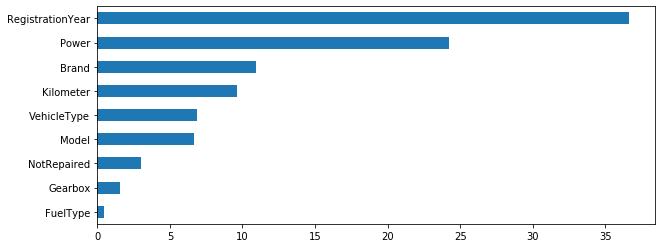

In [40]:
feat_importances = pd.Series(cb_model.feature_importances_, index=train_feats.columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

Как видно, важность признаков в этой модели немного отличается от LighGBM.

## XGBoost
Наконец, рассмотрим библиотеку XGBoost:

In [41]:
# Преобразуем данные в DMatrix
xgb_train = xgb.DMatrix(train_feats, label=train_target)
xgb_valid = xgb.DMatrix(valid_feats, label=valid_target)
xgb_test = xgb.DMatrix(test_feats, label=test_target)

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [42]:
xgb_parameters = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,
#     'gamma': 3,
    'max_depth': 9,
#     'subsample': 1,
    'colsample_bylevel': 0.6,
    'colsample_bytree': 0.6, 
}

xgb_model, t_fit = train_time(xgb,
                              params=xgb_parameters,
                              dtrain=xgb_train,
                              num_boost_round=2000,
                              evals=[(xgb_train, 'train'), (xgb_valid, 'valid')],
                              verbose_eval=200,
                              early_stopping_rounds=50)

[0]	train-rmse:6456.11	valid-rmse:6473.72
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[200]	train-rmse:1451.5	valid-rmse:1580
[400]	train-rmse:1360.96	valid-rmse:1541.96
[600]	train-rmse:1307.06	valid-rmse:1527.65
[800]	train-rmse:1269.29	valid-rmse:1521.3
[1000]	train-rmse:1235.78	valid-rmse:1517.23
[1200]	train-rmse:1211.85	valid-rmse:1516.05
Stopping. Best iteration:
[1187]	train-rmse:1212.74	valid-rmse:1516.02

Обучение закончено. Время обучения 646.483 секунд


Проверим на тестовом наборе:

In [43]:
rmse_test, t_predict = predict_time(xgb_model, xgb_test)
results.loc['XGBoost'] = [xgb_model.best_score, rmse_test, t_fit, t_predict]

Предсказание завершено. Время - 22.8107 сек, RMSE на тестовом наборе - 1514.3991263147361


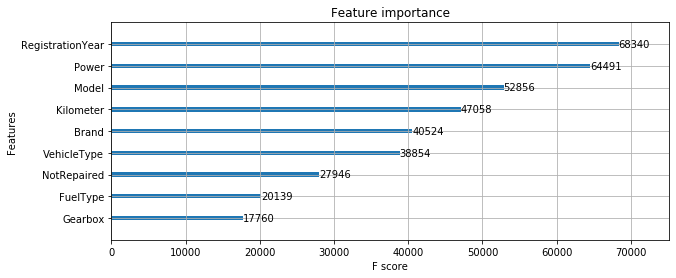

In [44]:
xgb.plot_importance(xgb_model)
plt.show()

# 4. Анализ моделей

В результате обучения наших моделей мы получили следующие метрики:

In [1]:
results.style.highlight_min(axis=0)

NameError: name 'results' is not defined

Как видно, все три модели бустинга показали лучший результат, чем базовая модель на основе алгоритма "Случайный лес". Лидером и по значению RMSE, и по времени работы стала модель LIghtGBM (ошибка на тесте - 1499 евро). Худшие результаты показал CatBoost. По скорости предсказания лучше всех CatBoost.

Рассмотрим параметры различных моделей:

In [46]:
lgb_parameters['best_iteration'] = lgb_model.best_iteration
pd.DataFrame.from_dict(lgb_parameters, orient='index', columns = ['LightGBM']).iloc[4:]

,LightGBM
num_leaves,512
learning_rate,0.03
max_bin,512
bagging_fraction,0.8
bagging_freq,1
best_iteration,452


In [47]:
cb_parameters['best_iteration'] = cb_model.best_iteration_
pd.DataFrame.from_dict(cb_parameters, orient='index', columns = ['CatBoost']).iloc[4:]

,CatBoost
depth,9
bagging_temperature,0
random_strength,3
best_iteration,4549


In [48]:
xgb_parameters['best_iteration'] = xgb_model.best_iteration
pd.DataFrame.from_dict(xgb_parameters, orient='index', columns = ['XGBoost']).iloc[2:]

,XGBoost
eta,0.05
max_depth,9
colsample_bylevel,0.6
colsample_bytree,0.6
best_iteration,1187


Оптимальной глубиной дерева для всех моделей оказалось 9 (в LightGBM мы задавали не глубину, а количество листов (512), глубина для двоичного дерева будет равна $\log_2 512 = 9$). Скорость обучения тоже оказалась примерно одинаковой и находится в рамках 0.03 - 0.05. Модель CatBoost при этом потребовала намного больше итераций (4549) для достижения минимума целевой функции.